In [1]:
from sklearn.utils import resample
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
# from sklearn.metrics import accuracy_score, classification_report


from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [22]:
!pip install imbalanced-learn


  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/6e/1b/66764ecf370e797759be06fb38c11640ea1f9456ae10f8640a33cfa726ea/imbalanced_learn-0.12.2-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/258.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/258.0 kB ? eta -:--:--
   - -------------------------------------- 10.2/258.0 kB ? eta -:--:--
   - -------------------------------------- 10.2/258.0 kB ? eta -:--:--
   ------ -------------------------------- 41.0/258.0 kB 245.8 kB/s eta 0:00:01
   --------- ----------------------------- 61.4/258.0 kB 328.2 kB/s eta 0:00:01
   ---------------- --------------------- 112.6/258.0 kB 504.4 kB/s eta 0:00:01
   ------------------------- ------------ 174.1/258.0 kB 655.4 kB/s eta 0:00:01
   ---------------------------------- --- 235.5/258.0 kB 758.5 kB/s eta 0:00:01
   -------------------------------------- 258.0/258.0 kB 720.2 kB/s eta 0:00:00


In [23]:
from imblearn.over_sampling import SMOTE

In [2]:
# Database connection details
host = 'localhost'
user = 'root'
port = 3306
password = 'Kofi1999$'
database = 'bet_prediction_model'

# Establish connection
connection = pymysql.connect(
    host=host,
    port=port,
    user=user,
    password=password,
    database=database
)

# Function to load data from a table
def load_data_from_db(connection, table_name):
    query = f"SELECT * FROM {table_name}"
    return pd.read_sql(query, connection)

# Load training and testing data
training_data = load_data_from_db(connection, 'training_data')
testing_data = load_data_from_db(connection, 'testing_data')

# Close the connection
connection.close()

C:\Users\kevin\AppData\Local\Temp\ipykernel_17020\159293122.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, connection)


In [3]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype          
---  ------                        --------------  -----          
 0   Home                          22 non-null     int64          
 1   Away                          22 non-null     int64          
 2   Home_Win_Probability          22 non-null     float64        
 3   Draw_Probability              22 non-null     float64        
 4   Away_Team_Win_Probability     22 non-null     float64        
 5   Team_To_Win_Prediction        22 non-null     int64          
 6   Average_Goals_Prediction      22 non-null     float64        
 7   Weather_In_Degrees            22 non-null     object         
 8   Odds                          22 non-null     float64        
 9   Full_Time_Score               22 non-null     object         
 10  Score_At_Halftime             22 non-null     object         
 11  Date                 

In [4]:
testing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Home                          20 non-null     int64         
 1   Away                          20 non-null     int64         
 2   Home Win probability          20 non-null     float64       
 3   Draw probability              20 non-null     float64       
 4   Away team win probability     20 non-null     float64       
 5   Team to win(prediction)       20 non-null     int64         
 6   Scoreline prediction          20 non-null     object        
 7   Average goals                 20 non-null     float64       
 8   Weather in degrees            20 non-null     object        
 9   Odds                          20 non-null     float64       
 10  Date                          20 non-null     datetime64[ns]
 11  Time                          20 n

In [5]:
# Drop unnecessary columns
training_data_columns_to_drop = ['Full_Time_Score', 'Score_At_Halftime']
training_data = training_data.drop(columns=training_data_columns_to_drop, axis =1)

In [6]:
# Separate minority and majority classes
loss = training_data[training_data['Prediction_Result_Won_Loss']==0]
win = training_data[training_data['Prediction_Result_Won_Loss']==1]

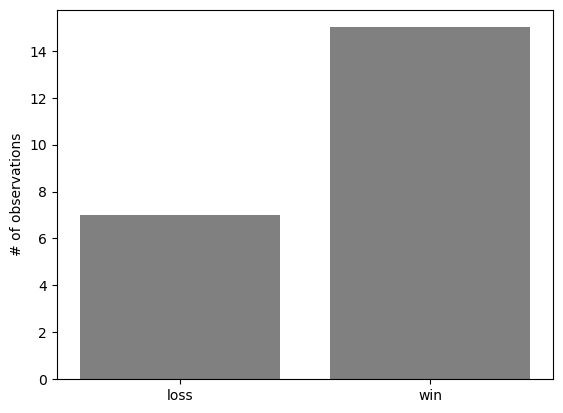

In [7]:
import matplotlib.pyplot as plt
labels = training_data['Prediction_Result_Won_Loss'].unique()
heights = [len(win),len(loss)]
plt.bar(labels,heights,color='grey')
plt.xticks(labels,['win','loss'])
plt.ylabel("# of observations")
plt.show()

In [8]:
loss_upsampled = resample(loss,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=len(win), # match number in minority class
                          random_state=27) # reproducible results

# Combine upsampled minority class with majority class
upsampled = pd.concat([loss_upsampled, win])

# Check new class counts
upsampled['Prediction_Result_Won_Loss'].value_counts()

Prediction_Result_Won_Loss
0    15
1    15
Name: count, dtype: int64

In [24]:
X = upsampled.drop(columns=['Prediction_Result_Won_Loss', 'Weather_In_Degrees','Date','Time'])
# Define your target variable y
y = upsampled['Prediction_Result_Won_Loss']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [25]:
# Define the names of the classifiers
names = ['Logistic Regression', 'Nearest Neighbors', 
         'Linear SVM', 'RBF SVM',          
         'Decision Tree', 'Random Forest',  'AdaBoost']

#### NOTE TO SELF  
You can use GridSearch to look for the best parameters for each model before proceeding to test their accuracy, but the data isnt enough at the moment 

In [28]:
# Define the classifiers with their respective hyperparameters
classifiers = [
    LogisticRegression(max_iter=20000, solver='lbfgs'), 
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),    
    AdaBoostClassifier()
]

In [29]:
# Empty lists to store results
results = []  # Store evaluation metrics for each classifier
models = {}  # Store trained models
confusion = {}  # Store confusion matrices for each classifier
class_report = {}  # Store classification reports for each classifier

# Iterate over each classifier
for name, clf in zip(names, classifiers):    
    print ('Fitting {:s} model...'.format(name))
    # Measure the time taken to fit the model
    run_time = %timeit -q -o clf.fit(X_train_resampled, y_train_resampled)
    
    print ('... predicting')
    # Predict on the training data
    y_pred = clf.predict(X_train)   
    y_pred_test = clf.predict(X_test)
    
    print ('... scoring')
    # Calculate evaluation metrics
    accuracy  = metrics.accuracy_score(y_train, y_pred)
    precision = metrics.precision_score(y_train, y_pred)
    recall    = metrics.recall_score(y_train, y_pred)
    
    f1        = metrics.f1_score(y_train, y_pred)    
    f1_test   = metrics.f1_score(y_test, y_pred_test)    
    
    # Save the results to dictionaries
    models[name] = clf    
    confusion[name] = metrics.confusion_matrix(y_train, y_pred)
    class_report[name] = metrics.classification_report(y_train, y_pred)
    
    # Append results to the list
    results.append([name, accuracy, precision, recall, f1, f1_test, run_time.best])

    
# Convert results to DataFrame for easy visualisation
results = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Train', 'F1 Test', 'Train Time'])
results.set_index('Classifier', inplace= True)

print ('... All done!')

Fitting Logistic Regression model...
... predicting
... scoring
Fitting Nearest Neighbors model...
... predicting
... scoring
Fitting Linear SVM model...
... predicting
... scoring
Fitting RBF SVM model...
... predicting
... scoring
Fitting Decision Tree model...
... predicting
... scoring
Fitting Random Forest model...
... predicting
... scoring
Fitting AdaBoost model...
... predicting
... scoring
... All done!


In [30]:
results.sort_values('F1 Train', ascending=False)

,Accuracy,Precision,Recall,F1 Train,F1 Test,Train Time
Classifier,,,,,,
Logistic Regression,1.000000,1.000000,1.000000,1.000000,0.857143,0.050386
Linear SVM,1.000000,1.000000,1.000000,1.000000,0.666667,0.005562
RBF SVM,1.000000,1.000000,1.000000,1.000000,1.000000,0.003326
Decision Tree,1.000000,1.000000,1.000000,1.000000,0.666667,0.004393
AdaBoost,1.000000,1.000000,1.000000,1.000000,0.666667,0.096369
Random Forest,0.958333,0.916667,1.000000,0.956522,0.857143,0.034508
Nearest Neighbors,0.916667,1.000000,0.818182,0.900000,0.666667,0.004866


Text(0.5, 1.0, 'Training Time vs. Classifier')

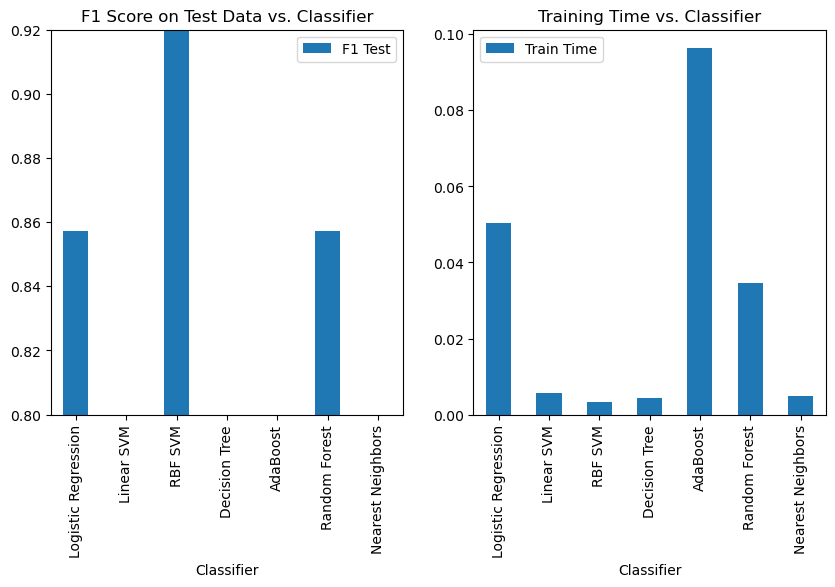

In [31]:
# Plot F1 Score on Test Data vs. Classifier
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
results.sort_values('F1 Train', ascending=False, inplace=True)
results.plot(y=['F1 Test'], kind='bar', ax=ax[0], xlim=[0,1.1], ylim=[0.80,0.92])
ax[0].set_title('F1 Score on Test Data vs. Classifier')
results.plot(y='Train Time', kind='bar', ax=ax[1])
ax[1].set_title('Training Time vs. Classifier')

In [15]:
# Display confusion matrices and classification reports
for name, matrix in confusion.items():
    print(f"Confusion Matrix for {name}:")
    print(matrix)
    print()
    
for name, report in class_report.items():
    print(f"Classification Report for {name}:")
    print(report)
    print()

Confusion Matrix for Logistic Regression:
[[12  0]
 [ 0 12]]

Confusion Matrix for Nearest Neighbors:
[[12  0]
 [ 2 10]]

Confusion Matrix for Linear SVM:
[[12  0]
 [ 0 12]]

Confusion Matrix for RBF SVM:
[[12  0]
 [ 0 12]]

Confusion Matrix for Decision Tree:
[[12  0]
 [ 0 12]]

Confusion Matrix for Random Forest:
[[12  0]
 [ 0 12]]

Confusion Matrix for AdaBoost:
[[12  0]
 [ 0 12]]

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        12

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24


Classification Report for Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        12
           1       1.00      0.83      0.91        12

    accuracy                

### CONCLUSION

- Keep in mind i had only 2 weekly rounds of data, thats maybe around 20 matches and 20 predictions to test these various models.
- Also there was data imbalance, this arises when the betting tip sites either win alot of their predictions or lose alot.
So i resampled using SMOTE, leading to duplicated data. Which in turn is a major drawback for training models, because you get high accuracy during training but little accuracy with new data. All in all we got three good models that we will create different notebooks for and explore them furthur 

- Logisitc Regression
- Random Forest
- RBF SVM

Im new to RBF so that will be interesting to play around with it.
Also, I might move on to new and other models to experiment with as the data grows and i get new revelation in F1 scores

It is always important to come back to this notebook and edit, tune, compare all the models again as the data increases and then with new information go back to the separate notebooks you have dedicated to your separate models and reaccess their accuracy by tuning certain parameters.

I will urge you to try PCA to look at ML from a different approach to also help classification.
Have fun!